In [1]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.4 MB/s eta 0:00:00


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": -0.17092,
	"longitude": -78.48494,
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "wind_speed_10m", "uv_index", "sunshine_duration"],
	"timezone": "auto",
	"start_date": "2025-03-02",
	"end_date": "2025-03-24"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_uv_index = hourly.Variables(4).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["uv_index"] = hourly_uv_index
hourly_data["sunshine_duration"] = hourly_sunshine_duration

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

Coordinates -0.25°N -78.5°E
Elevation 2786.0 m asl
Timezone b'America/Guayaquil'b'GMT-5'
Timezone difference to GMT+0 -18000 s
                         date  temperature_2m  relative_humidity_2m  \
0   2025-03-02 05:00:00+00:00       12.206000                  91.0   
1   2025-03-02 06:00:00+00:00       12.356000                  88.0   
2   2025-03-02 07:00:00+00:00       12.356000                  87.0   
3   2025-03-02 08:00:00+00:00       12.256001                  87.0   
4   2025-03-02 09:00:00+00:00       12.006001                  90.0   
..                        ...             ...                   ...   
547 2025-03-25 00:00:00+00:00       14.656000                  78.0   
548 2025-03-25 01:00:00+00:00       13.606000                  82.0   
549 2025-03-25 02:00:00+00:00       12.556000                  89.0   
550 2025-03-25 03:00:00+00:00       11.806000                  94.0   
551 2025-03-25 04:00:00+00:00       11.256001                  96.0   

     apparent_temper

In [63]:
df=hourly_dataframe

In [64]:
# Basic structure
#1.0 mm = 1 liter of rain over 1 square meter in 1 hour → Important for weather severity and hydrology.
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   date                  552 non-null    datetime64[ns, UTC]
 1   temperature_2m        552 non-null    float32            
 2   relative_humidity_2m  552 non-null    float32            
 3   apparent_temperature  552 non-null    float32            
 4   wind_speed_10m        552 non-null    float32            
 5   uv_index              552 non-null    float32            
 6   sunshine_duration     552 non-null    float32            
dtypes: datetime64[ns, UTC](1), float32(6)
memory usage: 17.4 KB
None
       temperature_2m  relative_humidity_2m  apparent_temperature  \
count      552.000000            552.000000            552.000000   
mean        13.645856             80.246376             13.238175   
std          2.910167             14.778736         

In [65]:
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.day_name()
df['month_day'] = df['date'].dt.strftime('%m-%d')


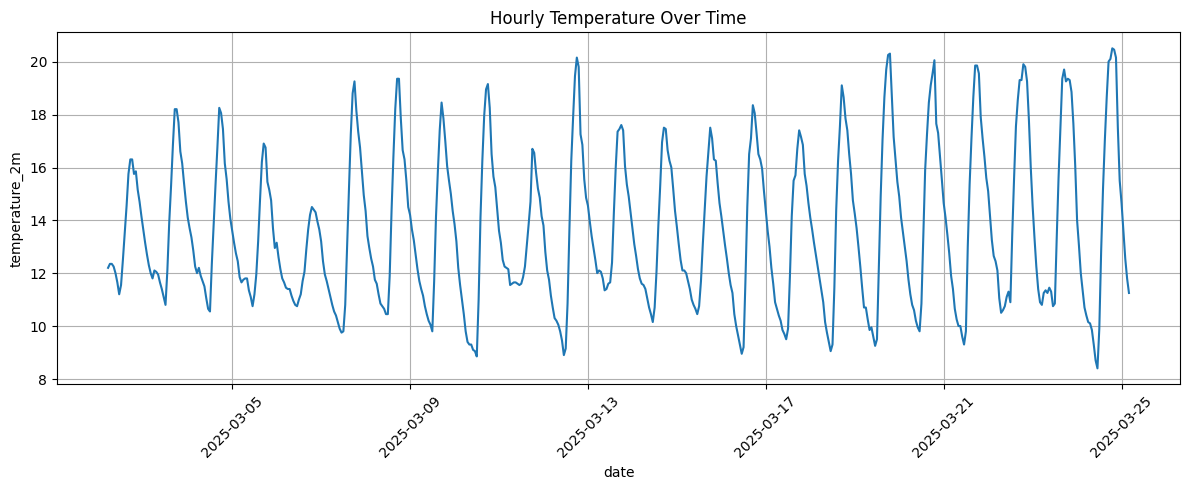

In [66]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='date', y='temperature_2m')
plt.title('Hourly Temperature Over Time')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


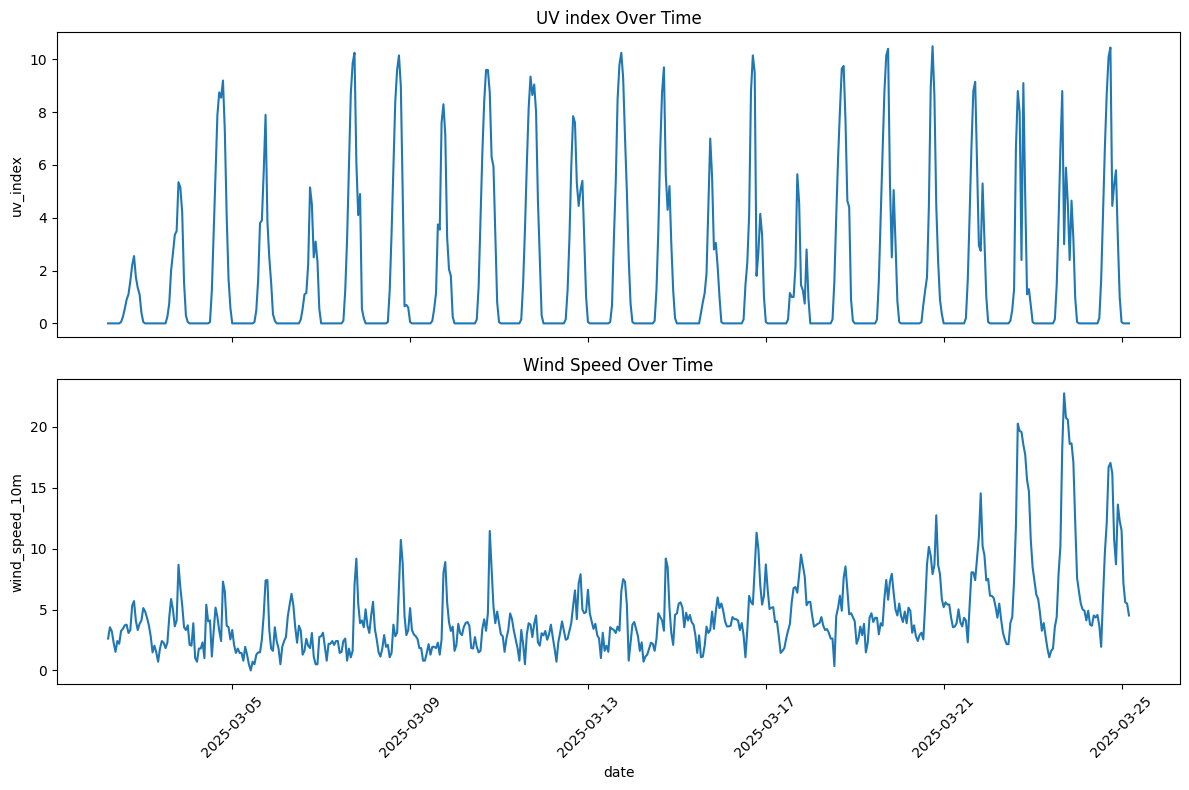

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
sns.lineplot(data=df, x='date', y='uv_index', ax=axs[0])
axs[0].set_title('UV index Over Time')
sns.lineplot(data=df, x='date', y='wind_speed_10m', ax=axs[1])
axs[1].set_title('Wind Speed Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


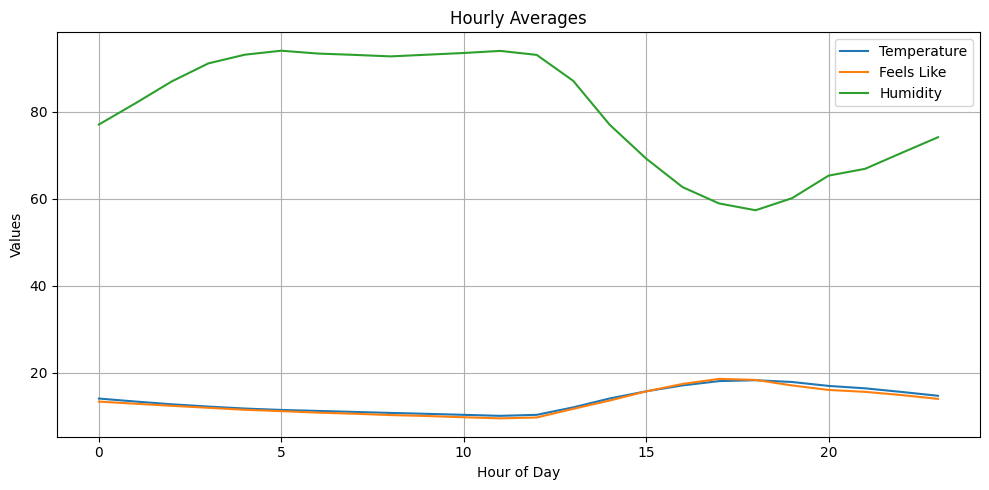

In [69]:
hourly_avg = df.groupby('hour').mean(numeric_only=True)

plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_avg.index, y=hourly_avg['temperature_2m'], label='Temperature')
sns.lineplot(x=hourly_avg.index, y=hourly_avg['apparent_temperature'], label='Feels Like')
sns.lineplot(x=hourly_avg.index, y=hourly_avg['relative_humidity_2m'], label='Humidity')
plt.title('Hourly Averages')
plt.xlabel('Hour of Day')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


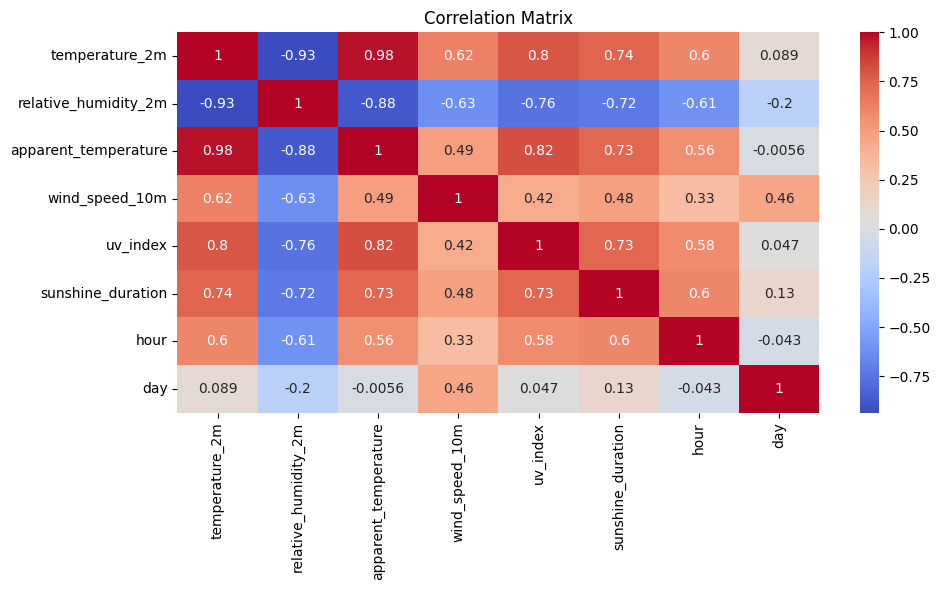

In [70]:
plt.figure(figsize=(10, 6))

# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


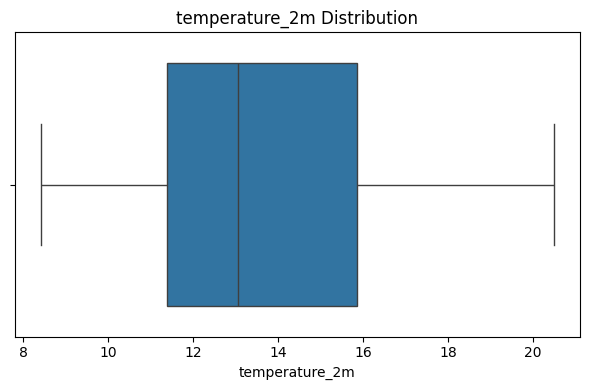

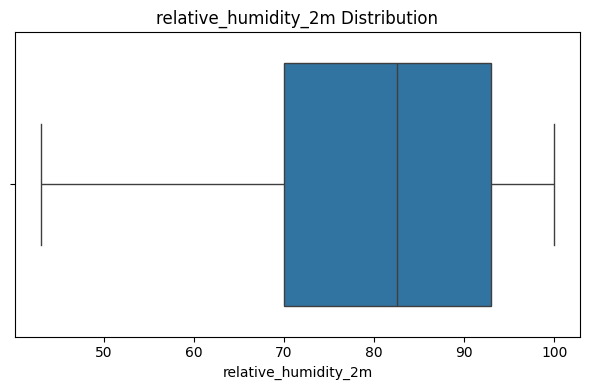

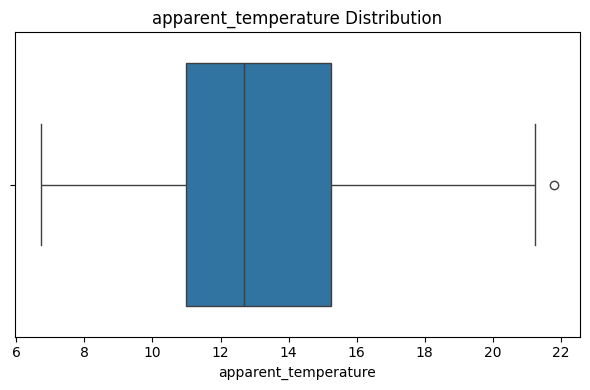

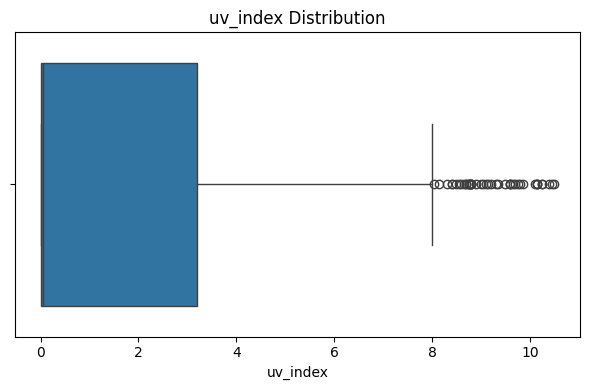

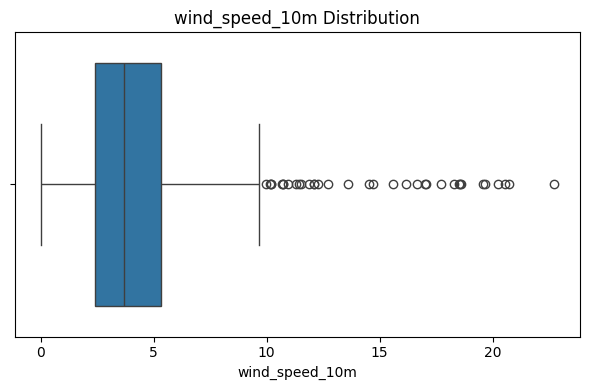

In [71]:
for col in ['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'uv_index', 'wind_speed_10m']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'{col} Distribution')
    plt.tight_layout()
    plt.show()

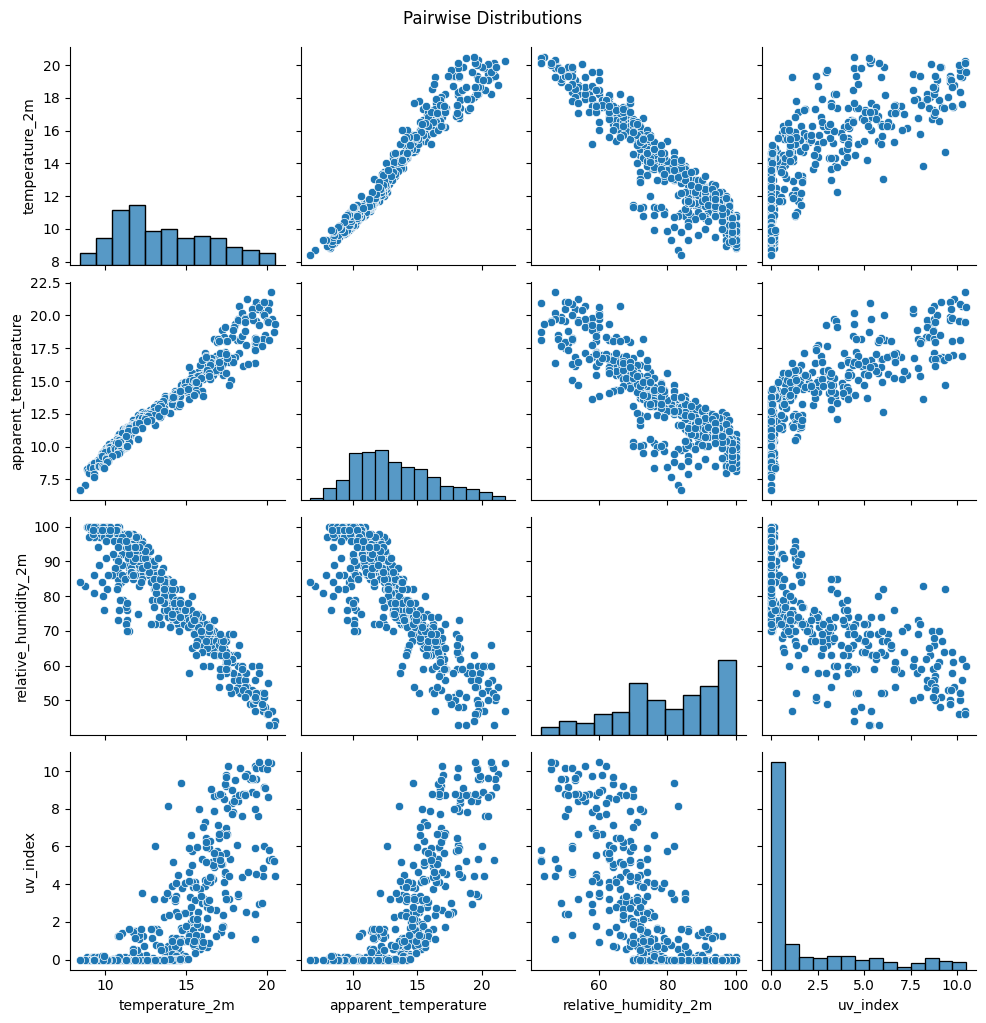

In [72]:
sns.pairplot(df[['temperature_2m', 'apparent_temperature', 'relative_humidity_2m', 'uv_index']])
plt.suptitle("Pairwise Distributions", y=1.02)
plt.show()

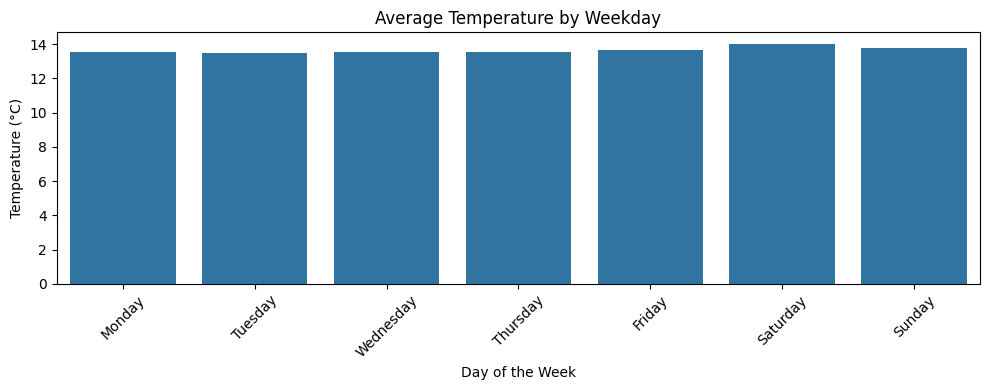

<ipython-input-73-b949c964e524>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekend_comparison.index, y=weekend_comparison.values, palette='Set2')


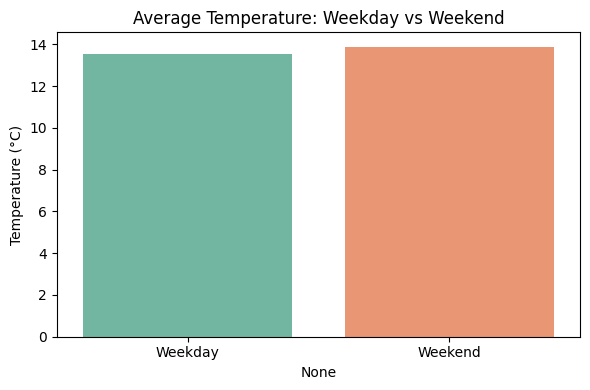

In [73]:
# Create weekday and weekend labels
df['weekday_name'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.dayofweek >= 5  # 5 = Saturday, 6 = Sunday

# Average temperature per weekday
weekday_avg = df.groupby('weekday_name')['temperature_2m'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Average temperature: Weekday vs. Weekend
weekend_comparison = df.groupby('is_weekend')['temperature_2m'].mean()
weekend_comparison.index = ['Weekday', 'Weekend']

# Plot weekday average temperature
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values)
plt.title("Average Temperature by Weekday")
plt.ylabel("Temperature (°C)")
plt.xlabel("Day of the Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot comparison: Weekday vs. Weekend
plt.figure(figsize=(6, 4))
sns.barplot(x=weekend_comparison.index, y=weekend_comparison.values, palette='Set2')
plt.title("Average Temperature: Weekday vs Weekend")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.show()
